In [2]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap,shiftgrid

from matplotlib import colors as c

In [9]:
#读数据
filepath = 'https://power-analysis-ready-datastore.s3.amazonaws.com/power_901_monthly_meteorology_utc.zarr'
filepath_mapped = fsspec.get_mapper(filepath)
ds = xr.open_zarr(store=filepath_mapped, consolidated=True)
ds

<xarray.Dataset>
Dimensions:          (time: 504, lat: 361, lon: 576)
Coordinates:
  * lat              (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * lon              (lon) float64 -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
  * time             (time) datetime64[ns] 1981-01-31 1981-02-28 ... 2022-12-31
Data variables: (12/94)
    CDD0             (time, lat, lon) float64 ...
    CDD10            (time, lat, lon) float64 ...
    CDD18_3          (time, lat, lon) float64 ...
    DISPH            (time, lat, lon) float64 ...
    EVLAND           (time, lat, lon) float64 ...
    EVPTRNS          (time, lat, lon) float64 ...
    ...               ...
    WS50M_MAX_AVG    (time, lat, lon) float64 ...
    WS50M_MIN        (time, lat, lon) float64 ...
    WS50M_MIN_AVG    (time, lat, lon) float64 ...
    WS50M_RANGE      (time, lat, lon) float64 ...
    WS50M_RANGE_AVG  (time, lat, lon) float64 ...
    Z0M              (time, lat, lon) float64 ...
Attributes: (12/37)
    acknowledgement:            The Prediction of Worldwide Energy Resources ...
    comment:                    Version 9.0.1 includes source data resolution.
    conventions:                CF-1.8, ACDD-1.3
    creator_email:              bradley.macpherson@nasa.gov
    creator_name:               Bradley Macpherson
    date_created:               2023-09-20T09:00:00.000000
    ...                         ...
    time_coverage_end:          2022-12-31T00:00:00
    time_coverage_resolution:   P1M
    time_coverage_start:        1981-01-01T00:00:00
    time_standard:              Universal Time Coordinated (UTC)
    title:                      POWER Monthly Meteorology Time Series
    version:                    POWER Version 9.0.1

In [10]:
# a1是每个点的风速从1984-2022求平均,a2风向值，a3温度，a4压力，SNODP降雪深度
#特征含义请参考https://power.larc.nasa.gov/#resources
ds.WS50M_RANGE_AVG.data[np.where(ds.WS50M_RANGE_AVG.data>11)]=0
WS50M_RANGE_AVG_asian = ds.WS50M_RANGE_AVG.loc[:,-10:80,-25:170]
WD50M_asian = ds.WD50M.loc[:,-10:80,-25:170]
TS_asian = ds.TS.loc[:,-10:80,-25:170]
PS_asian = ds.PS.loc[:,-10:80,-25:170]
SNODP_asian = ds.SNODP.loc[:,-10:80,-25:170]

a1 = WS50M_RANGE_AVG_asian.mean(dim='time')
a2 = np.abs(WD50M_asian.diff(dim='time')).mean(dim='time')
a3 = TS_asian.mean(dim='time')
a4 = PS_asian.mean(dim='time')
a5 = SNODP_asian.mean(dim='time')

#标准化
mi1 = np.min(a1)
ma1 = np.max(a1)
standardized_data1 = (a1 - mi1) / (ma1-mi1)

mi2 = np.min(a2)
ma2 = np.max(a2)
standardized_data2 = (a2 - mi2) / (ma2-mi2)

#温度
a3.data[np.where(a3.data>=-20)]=1
a3.data[np.where(a3.data<-20)]=0

#气压
a4.data[np.where(a4.data<58000)]=0
a4.data[np.where(a4.data>58000)]=1

#雪线
#a5.data[np.where(a4.data<1)]=1
#a5.data[np.where(a4.data>1)]=0

#专家规则
feature = (2*standardized_data1 - standardized_data2)*a4*a3

lon = np.array(a1['lon'])
lat = np.array(a1['lat'])
# time = np.array(a['time'])
data = np.array(feature)

In [12]:
import pandas as pd
path = "/home/ec2-user/SageMaker/data/global_power_plant_database.csv"

In [13]:
df = pd.read_csv(path)

/tmp/ipykernel_960/3280352130.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [14]:
plant_data=df[df['primary_fuel']=='Wind']

/tmp/ipykernel_960/793397010.py:26: UserWarning: The following kwargs were not used by contour: 'shading'
  cs = map.contourf(x,y,VO, cmap=cmap, norm=norm, levels=bounds,shading='interp')


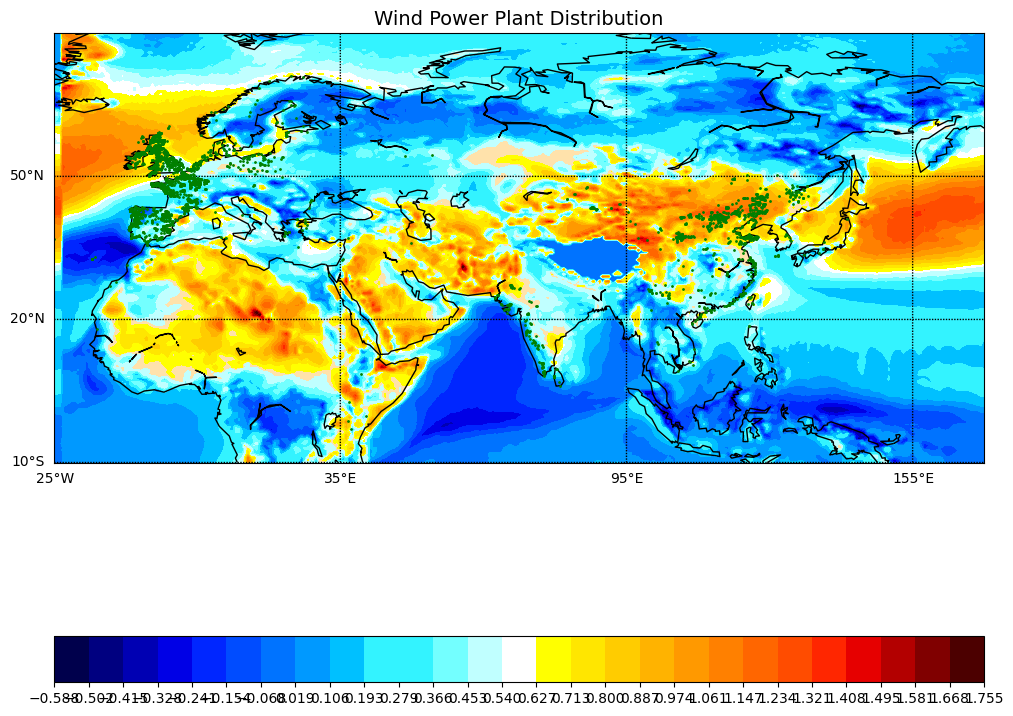

In [16]:
#这是化全球范围的图
fig = plt.figure(figsize=[12,15])  # 新窗口
ax = fig.add_subplot(1, 1, 1)  # 添加子图
ax.set_title('Wind Power Plant Distribution', fontsize=14)
 
map = Basemap(projection='cyl',llcrnrlat=-10,urcrnrlat=80, llcrnrlon=-25,urcrnrlon=170,resolution='c', ax=ax)
map.drawcoastlines()
map.fillcontinents(color='#ffe2ab')
# 添加经纬度
map.drawparallels(np.arange(-10.,80.,30.),labels=[1,0,0,0])
map.drawmeridians(np.arange(-25.,170.,60.),labels=[0,0,0,1])
map.plot(plant_data['longitude'],plant_data['latitude'],'go', markersize=1)
# 经度范围设置为[30,150]
VO, lons = shiftgrid(169.,data,lon,start=False)
llons, llats = np.meshgrid(lon, lat)
x,y = map(llons,llats)
# 设置色阶
cmap = c.ListedColormap(['#00004c','#000080','#0000b3','#0000e6','#0026ff','#004cff',
                         '#0073ff','#0099ff','#00c0ff','#33f3ff','#33f3ff','#73ffff','#c0ffff', 
                         (0,0,0,0),
                         '#ffff00','#ffe600','#ffcc00','#ffb300','#ff9900','#ff8000','#ff6600',
                         '#ff4c00','#ff2600','#e60000','#b30000','#800000','#4c0000'])
bounds=np.linspace(data.min(),data.max(),28)
# bounds=[0,100,200,300,400,500,600,700,800,1000]
norm = c.BoundaryNorm(bounds, ncolors=cmap.N) 
cs = map.contourf(x,y,VO, cmap=cmap, norm=norm, levels=bounds,shading='interp')
# 添加颜色条
fig.colorbar(cs, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, ax=ax, orientation='horizontal')


In [17]:
fig.savefig("my_figure.jpg")